## SENSE Example

This code essentially applies the same operations as in Basic Example, but including sensitivity maps from simulated sensitivity coils. The coil multiplications and NUFFT operations are broadcast multiplied by default, giving rapid computations.

### Note

This notebook uses the shepp_logan_phantom from scikit-image, which is included in scikit-image v0.16. The standard Anaconda scikit-image as of this writing is 0.15. To use this notebook, you'll need to upgrade scikit-image to v0.16, e.g. ```conda install -c conda-forge scikit-image=0.16```.

### References

Fessler, J. A., & Sutton, B. P. (2003). Nonuniform fast Fourier transforms using min-max interpolation. IEEE transactions on signal processing, 51(2), 560-574.

Beatty, P. J., Nishimura, D. G., & Pauly, J. M. (2005). Rapid gridding reconstruction with a minimal oversampling ratio. IEEE transactions on medical imaging, 24(6), 799-808.

Pruessmann, K. P., Weiger, M., Scheidegger, M. B., & Boesiger, P. (1999). SENSE: sensitivity encoding for fast MRI. Magnetic resonance in medicine, 42(5), 952-962.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
from skimage.data import shepp_logan_phantom

from mrisensesim import mrisensesim

dtype = torch.complex64

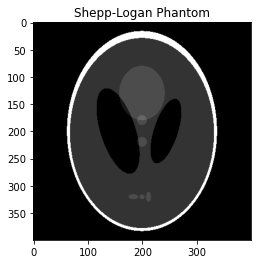

In [2]:
# create a simple shepp logan phantom and plot it
image = shepp_logan_phantom().astype(np.complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

In [3]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image = torch.tensor(image, dtype=dtype).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image.shape))

image shape: torch.Size([1, 1, 400, 400])


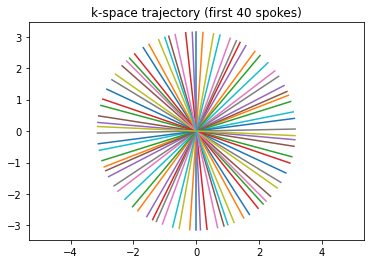

In [4]:
# create a k-space trajectory and plot it
spokelength = image.shape[-1] * 2
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()

In [5]:
# convert k-space trajectory to a tensor and unsqueeze batch dimension
ktraj = torch.tensor(ktraj, dtype=torch.float)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([2, 324000])


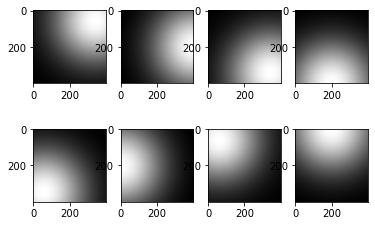

In [6]:
# simulate some sensitivity coils (no phase for simplicity)
ncoil = 8
smap = np.absolute(np.stack(mrisensesim(im_size, coil_width=64))).astype(np.complex)

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    ax.imshow(np.absolute(smap[i]))
plt.gray()
    
plt.show()

In [7]:
# convert smaps to tensors, unsqueeze batch dimension
smap = torch.tensor(smap, dtype=dtype).unsqueeze(0)

In [8]:
# build nufft operators
nufft_ob = tkbn.KbNufft(im_size=im_size, grid_size=grid_size).to(image)
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=im_size, grid_size=grid_size).to(image)

print(nufft_ob)
print(adjnufft_ob)


KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)



In [9]:
# calculate k-space data
kdata = nufft_ob(image, ktraj, smaps=smap)
# add some noise (robustness test)
siglevel = torch.abs(kdata).mean()
kdata = kdata + (siglevel/5) * torch.randn(kdata.shape)

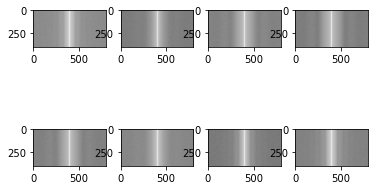

In [10]:
# convert kdata to numpy and plot
kdata_numpy = np.reshape(kdata.numpy(), (ncoil, nspokes, spokelength))

fig, axs = plt.subplots(2, 4)
for i, ax in enumerate(axs.flat):
    ax.imshow(np.log10(np.absolute(kdata_numpy[i])))
plt.gray()
    
plt.show()

In [11]:
# adjnufft back
# method 1: no density compensation (blurry image)
image_blurry = adjnufft_ob(kdata, ktraj, smaps=smap)

# method 2: use density compensation
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj, smaps=smap)

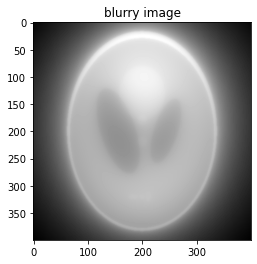

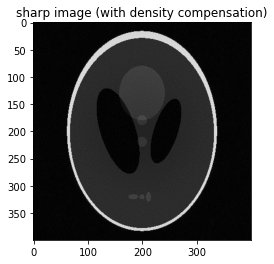

In [12]:
# show the images, some phase errors may occur due to smap
image_blurry_numpy = np.squeeze(image_blurry.numpy())

image_sharp_numpy = np.squeeze(image_sharp.numpy())

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()
plt.title('blurry image')

plt.figure(1)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.title('sharp image (with density compensation)')

plt.show()